In [1]:
import datetime

import numpy as np
import pandas as pd

from src.data_handler import CoinDataStore
from src.simple_wash_detector_utils import detect_wash_trades_nearest

In [2]:
store = CoinDataStore("AVAX", engine="fastparquet")
df_matched = store.load_all()
df_matched

,price,size,time,seller,buyer
0,19.521999,213.199997,2025-03-22 10:50:22.930512310,8,658
1,19.521999,1.000000,2025-03-22 10:50:23.731759790,19,658
2,19.525999,11.820000,2025-03-22 10:50:43.490273671,161,1260
3,19.525999,39.150002,2025-03-22 10:50:43.490273671,161,19500
4,19.525000,8.800000,2025-03-22 10:50:43.490273671,161,240
...,...,...,...,...,...
1478242,24.966999,1.210000,2025-07-27 08:44:33.762000000,8,1527
1478243,24.971001,308.359985,2025-07-27 08:44:59.437000000,161,5135
1478244,24.971001,203.639999,2025-07-27 08:44:59.437000000,892,5135
1478245,24.971001,11.940000,2025-07-27 08:45:07.130000000,19,170117


In [3]:
df_matched = df_matched.sort_values('time')
df_matched['time'] = pd.to_datetime(df_matched['time'])

In [4]:
sells = df_matched[["seller", "time", "price", "size"]].rename(columns={"seller": "wallet_id"}).copy()
sells["is_ask"] = True

buys = df_matched[["buyer", "time", "price", "size"]].rename(columns={"buyer": "wallet_id"}).copy()
buys["is_ask"] = False

df_all = pd.concat([sells, buys], ignore_index=True)

df_all["notional"] = df_all["price"] * df_all["size"]
df_all = df_all.groupby(["wallet_id", "time", "is_ask"]).agg(size=("size", "sum"), notional=("notional", "sum")).reset_index()
df_all["price"] = (df_all["notional"] / df_all["size"]).astype("float32")
df_all = df_all.drop("notional", axis=1)
df_all

,wallet_id,time,is_ask,size,price
0,1,2025-06-30 19:16:16.060,False,47.049999,18.014999
1,1,2025-06-30 19:16:46.011,False,47.049999,18.025000
2,1,2025-06-30 19:17:17.005,False,47.059998,18.030884
3,1,2025-06-30 19:17:46.024,False,47.049999,18.018999
4,1,2025-06-30 19:18:16.077,False,47.059998,18.011999
...,...,...,...,...,...
2265245,272404,2025-06-23 16:40:53.219,True,959.900024,16.377071
2265246,272404,2025-06-23 16:45:39.769,False,959.900024,16.470161
2265247,274311,2025-06-15 15:19:18.194,True,2.710000,19.183001
2265248,274311,2025-06-15 17:27:03.505,False,2.710000,19.049000


In [5]:
def inter_direction_times(group):
    directions = group['is_ask'].values
    times = group['time'].values
    change_idx = np.where(directions[1:] != directions[:-1])[0]

    if len(change_idx) == 0:
        return pd.Series({
            'inter_dir_q25': np.nan,
            'inter_dir_q75': np.nan,
            'inter_dir_gaps': []
        })

    gaps = (times[change_idx + 1] - times[change_idx]) / np.timedelta64(1, 's')

    q25, q75 = np.percentile(gaps, [25, 75]) if len(gaps) > 0 else (np.nan, np.nan)
    return pd.Series({
        'inter_dir_q25': q25,
        'inter_dir_q75': q75,
        'inter_dir_gaps': [gaps]
    })

inter_dir_features = (
    df_all.groupby('wallet_id')
    .apply(inter_direction_times)
    .reset_index()
)

/tmp/ipykernel_9097/217413703.py:24: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  .apply(inter_direction_times)


In [6]:
def burstiness_ci(gaps, n_boot=200):
    # Flatten list of arrays to one vector
    if not isinstance(gaps, (list, np.ndarray)) or len(gaps) == 0:
        return pd.Series({'burstiness': np.nan, 'ci_low': np.nan, 'ci_high': np.nan})
    x = np.array(gaps).flatten()
    x = x[~np.isnan(x)]
    if len(x) < 3:
        return pd.Series({'burstiness': np.nan, 'ci_low': np.nan, 'ci_high': np.nan})

    mean, std = np.mean(x), np.std(x)
    if mean == 0:
        return pd.Series({'burstiness': np.nan, 'ci_low': np.nan, 'ci_high': np.nan})

    burst = std / mean
    boots = []
    for _ in range(n_boot):
        sample = np.random.choice(x, len(x), replace=True)
        boots.append(np.std(sample) / np.mean(sample))

    return pd.Series({
        'burstiness': burst,
        'ci_low': np.percentile(boots, 2.5),
        'ci_high': np.percentile(boots, 97.5),
        'ci_diff': np.percentile(boots, 97.5) - np.percentile(boots, 2.5)
    })

burst_features = inter_dir_features[['wallet_id', 'inter_dir_gaps']].copy()
burst_features = burst_features.join(
    burst_features['inter_dir_gaps'].apply(burstiness_ci)
)
burst_features = burst_features.drop(columns=['inter_dir_gaps'])

In [7]:
from scipy.stats import entropy
df_all['hour'] = df_all['time'].dt.hour

def hourly_entropy(x):
    counts = x.value_counts(normalize=True)
    return entropy(counts, base=np.e)

hourly_entropy_feature = (
    df_all.groupby('wallet_id')['hour']
    .apply(hourly_entropy)
    .rename('hourly_activity_entropy')
)


In [8]:
df_all['hour_bin'] = df_all['time'].dt.floor('H')

agg_hour = (
    df_all.groupby(['wallet_id', 'hour_bin'])
    .agg(volume=('size', 'sum'),
         price_mean=('price', 'mean'),
         price_std=('price', 'std'))
    .reset_index()
)

total_volume = (
    df_all.groupby('hour_bin')['size']
    .sum()
    .rename('total_volume')
    .reset_index()
)

agg_hour = agg_hour.merge(total_volume, on='hour_bin', how='left')

def corr_metrics(x):
    # Skip wallets with too few points
    if x['volume'].nunique() < 2:
        return pd.Series({
            'corr_vol_price_change': np.nan,
            'corr_vol_price_var': np.nan,
            'corr_vol_total': np.nan
        })
    return pd.Series({
        'corr_vol_price_change': x['volume'].corr(x['price_mean']),
        'corr_vol_price_var': x['volume'].corr(x['price_std']),
        'corr_vol_total': x['volume'].corr(x['total_volume'])
    })

corr_features = (
    agg_hour.groupby('wallet_id')
    .apply(corr_metrics)
    .reset_index()
)

corr_features.head()

/tmp/ipykernel_9097/3560141778.py:1: FutureWarning: 'H' is deprecated and will be removed in a future version, please use 'h' instead.
  df_all['hour_bin'] = df_all['time'].dt.floor('H')
/home/asevlad/anaconda3/lib/python3.13/site-packages/numpy/lib/_function_base_impl.py:2991: RuntimeWarning: Degrees of freedom <= 0 for slice
  c = cov(x, y, rowvar, dtype=dtype)
/home/asevlad/anaconda3/lib/python3.13/site-packages/numpy/lib/_function_base_impl.py:2848: RuntimeWarning: divide by zero encountered in divide
  c *= np.true_divide(1, fact)
/home/asevlad/anaconda3/lib/python3.13/site-packages/numpy/lib/_function_base_impl.py:2848: RuntimeWarning: invalid value encountered in multiply
  c *= np.true_divide(1, fact)
/home/asevlad/anaconda3/lib/python3.13/site-packages/numpy/lib/_function_base_impl.py:2999: RuntimeWarning: invalid value encountered in divide
  c /= stddev[:, None]
/home/asevlad/anaconda3/lib/python3.13/site-packages/numpy/lib/_function_base_impl.py:3000: RuntimeWarning: invali

,wallet_id,corr_vol_price_change,corr_vol_price_var,corr_vol_total
0,1,0.265787,0.974336,0.999349
1,3,0.004572,0.373802,0.570454
2,5,-0.048225,0.088345,0.446239
3,6,-0.099909,0.161523,0.418365
4,7,-0.055087,0.079607,0.476944


In [9]:
temporal_features = (
    inter_dir_features[["wallet_id", "inter_dir_q25", "inter_dir_q75"]]
    .merge(burst_features, on='wallet_id', how='outer')
    .merge(hourly_entropy_feature, on='wallet_id', how='outer')
    .merge(corr_features, on='wallet_id', how='outer')
)

In [10]:
temporal_features = temporal_features.merge(
    df_all.groupby("wallet_id")["size"].sum().reset_index().rename({"size": "volume"}, axis=1),
    on="wallet_id",
    how="inner",
).merge(
    df_all.groupby("wallet_id")["size"].count().reset_index().rename({"size": "count"}, axis=1),
    on="wallet_id",
    how="inner",
)

In [23]:
temporal_features

,wallet_id,inter_dir_q25,inter_dir_q75,burstiness,ci_low,ci_high,ci_diff,hourly_activity_entropy,corr_vol_price_change,corr_vol_price_var,corr_vol_total,volume,count
0,1,20645.635000,20645.635000,NaN,NaN,NaN,NaN,0.769738,0.265787,0.974336,0.999349,4800.000000,69
1,3,11.334127,923.333500,4.073870,2.707111,4.987659,2.280548,3.005802,0.004572,0.373802,0.570454,711997.875000,3937
2,5,2082.892340,17220.403000,8.781987,1.290587,9.457724,8.167136,3.111425,-0.048225,0.088345,0.446239,101469.781250,2156
3,6,2217.443355,14453.644126,2.196128,1.547336,2.641356,1.094020,3.115243,-0.099909,0.161523,0.418365,160148.187500,3275
4,7,785.130000,6752.205922,2.611751,1.750383,3.230792,1.480409,3.132419,-0.055087,0.079607,0.476944,216830.234375,5523
...,...,...,...,...,...,...,...,...,...,...,...,...,...
10630,271895,5752.241000,44209.640000,1.152154,0.000000,1.200914,1.200914,1.583258,-0.385314,1.000000,0.867330,637.720032,12
10631,272337,75406.695000,75406.695000,NaN,NaN,NaN,NaN,0.693147,1.000000,NaN,-1.000000,119.320007,2
10632,272404,286.550000,286.550000,NaN,NaN,NaN,NaN,0.000000,NaN,NaN,NaN,1919.800049,2
10633,274311,7665.311000,7665.311000,NaN,NaN,NaN,NaN,0.693147,NaN,NaN,NaN,5.420000,2


## Entropy of trading volume across counterparties

In [24]:
def compute_entropy(df_matched):
    df = df_matched[['seller', 'buyer', 'size']].copy()

    seller_grouped = df.groupby(['seller', 'buyer'], as_index=False)['size'].sum()

    def entropy(series):
        p = series / series.sum()
        return -(p * np.log(p)).sum()

    seller_entropy = (
        seller_grouped.groupby('seller')['size']
        .apply(entropy)
        .reset_index(name='seller_entropy')
    )

    buyer_grouped = df.groupby(['buyer', 'seller'], as_index=False)['size'].sum()

    buyer_entropy = (
        buyer_grouped.groupby('buyer')['size']
        .apply(entropy)
        .reset_index(name='buyer_entropy')
    )

    entropy_features = (
        pd.merge(seller_entropy, buyer_entropy, left_on='seller', right_on='buyer', how='outer')
        .rename(columns={'seller': 'wallet_id'})
    )

    entropy_features['wallet_id'] = entropy_features['wallet_id'].fillna(entropy_features['buyer'])
    entropy_features = entropy_features[['wallet_id', 'seller_entropy', 'buyer_entropy']]

    entropy_features = entropy_features.fillna(0)

    entropy_features['total_entropy'] = entropy_features['seller_entropy'] + entropy_features['buyer_entropy']

    return entropy_features


In [25]:
entropy_df = compute_entropy(df_matched)
entropy_df.head()

,wallet_id,seller_entropy,buyer_entropy,total_entropy
0,1.0,1.953551,2.678925,4.632475
1,3.0,4.319869,4.034076,8.353945
2,5.0,3.905228,3.976908,7.882136
3,6.0,3.532740,3.549585,7.082325
4,7.0,3.924761,3.937603,7.862364


In [26]:
entropy_df = entropy_df.merge(
    df_all.groupby("wallet_id")["size"].sum().reset_index().rename({"size": "volume"}, axis=1),
    on="wallet_id",
    how="inner",
).merge(
    df_all.groupby("wallet_id")["size"].count().reset_index().rename({"size": "count"}, axis=1),
    on="wallet_id",
    how="inner",
)

In [27]:
entropy_df[(entropy_df["count"] > 100) & (entropy_df["buyer_entropy"] < 1.5)].sort_values("buyer_entropy")

,wallet_id,seller_entropy,buyer_entropy,total_entropy,volume,count
2711,19569.0,2.511521,0.000000,2.511521,8715.919922,517
2777,19893.0,2.370097,0.000000,2.370097,950.820007,113
3789,27508.0,2.312943,-0.000000,2.312943,376.160004,117
7143,56099.0,2.060997,0.000000,2.060997,5063.000000,102
9501,168874.0,2.824775,0.000000,2.824775,16221.400391,4056
6546,50851.0,2.632891,0.298086,2.930977,4290.839844,185
4182,30431.0,2.064757,0.631364,2.696121,1193.400024,103
3585,25815.0,2.049526,0.650901,2.700428,916.339966,124
567,2542.0,2.530237,0.681055,3.211292,250.000000,124
4989,36895.0,2.900711,0.688633,3.589343,13303.549805,197


## Reciprocity counterparty ratio

In [28]:
import pandas as pd
import numpy as np

def compute_reciprocity_features_hourly(df_matched):
    df = df_matched[['seller', 'buyer', 'size', 'time']].copy()
    df['time'] = pd.to_datetime(df['time'])

    # Step 1: create 1-hour time window
    df['hour_window'] = df['time'].dt.floor('1H')

    # Step 2: aggregate volume per direction & hour
    flow = (
        df.groupby(['hour_window', 'seller', 'buyer'], as_index=False)['size']
        .sum()
        .rename(columns={'size': 'V_1to2'})
    )

    # Step 3: prepare reverse direction (buyer→seller, same hour)
    reverse_flow = flow.rename(columns={'seller': 'buyer', 'buyer': 'seller', 'V_1to2': 'V_2to1'})

    # Step 4: merge both directions for same time window
    merged = pd.merge(flow, reverse_flow, on=['hour_window', 'seller', 'buyer'], how='outer').fillna(0)

    # Step 5: compute ratio and features
    merged['R'] = merged[['V_1to2', 'V_2to1']].min(axis=1) / merged[['V_1to2', 'V_2to1']].max(axis=1)
    merged['R'] = merged['R'].fillna(0)

    merged['R_prime'] = merged['R'] * np.log(merged['V_1to2'] + merged['V_2to1'] + 1)
    merged['D'] = (merged['V_1to2'] - merged['V_2to1']) / (merged['V_1to2'] + merged['V_2to1'])
    merged['D'] = merged['D'].fillna(0)

    return merged[['hour_window', 'seller', 'buyer', 'V_1to2', 'V_2to1', 'R', 'R_prime', 'D']]

In [29]:
def wallet_reciprocal_intensity(hourly_df):
    df = hourly_df.copy()
    df['total_vol'] = df['V_1to2'] + df['V_2to1']
    # contribution of this pair-hour to reciprocity
    df['weighted_R'] = df['R_prime'] * df['total_vol']

    # sum over both roles
    sellers = (
        df.groupby('seller', as_index=False)[['weighted_R','total_vol']]
          .sum().rename(columns={'seller':'wallet'})
    )
    buyers = (
        df.groupby('buyer', as_index=False)[['weighted_R','total_vol']]
          .sum().rename(columns={'buyer':'wallet'})
    )

    combined = pd.concat([sellers, buyers]).groupby('wallet', as_index=False).sum()
    combined['RVI'] = combined['weighted_R'] / combined['total_vol']
    return combined[['wallet','RVI']]


In [30]:
def wallet_directional_asymmetry(hourly_df):
    df = hourly_df.copy()
    df['total_vol'] = df['V_1to2'] + df['V_2to1']
    df['weighted_absD'] = np.abs(df['D']) * df['total_vol']

    sellers = (
        df.groupby('seller', as_index=False)[['weighted_absD','total_vol']]
          .sum().rename(columns={'seller':'wallet'})
    )
    buyers = (
        df.groupby('buyer', as_index=False)[['weighted_absD','total_vol']]
          .sum().rename(columns={'buyer':'wallet'})
    )

    combined = pd.concat([sellers, buyers]).groupby('wallet', as_index=False).sum()
    combined['DA'] = 1 - (combined['weighted_absD'] / combined['total_vol'])
    return combined[['wallet','DA']]


In [31]:
hourly_df = compute_reciprocity_features_hourly(df_matched)
rvi = wallet_reciprocal_intensity(hourly_df)
da  = wallet_directional_asymmetry(hourly_df)
wallet_features = pd.merge(rvi, da, on='wallet', how='outer')

/tmp/ipykernel_9097/2145406501.py:9: FutureWarning: 'H' is deprecated and will be removed in a future version, please use 'h' instead.
  df['hour_window'] = df['time'].dt.floor('1H')


In [32]:
wallet_features = wallet_features.rename({"wallet": "wallet_id"}, axis=1).merge(
    df_all.groupby("wallet_id")["size"].sum().reset_index().rename({"size": "volume"}, axis=1),
    on="wallet_id",
    how="inner",
).merge(
    df_all.groupby("wallet_id")["size"].count().reset_index().rename({"size": "count"}, axis=1),
    on="wallet_id",
    how="inner",
)

In [33]:
wallet_features[(wallet_features["count"] > 100) & (wallet_features["volume"] > 100000)].sort_values("DA").head(50)

,wallet_id,RVI,DA,volume,count
38,82,0.000000,0.000000,1.635614e+05,12813
33,64,0.000000,0.000000,3.005856e+05,6780
970,5742,0.000000,0.000000,1.169148e+05,495
1205,7559,0.000000,0.000000,6.398774e+05,5918
1825,12367,0.000000,0.000000,3.828247e+05,583
2088,14468,0.000000,0.000000,3.013505e+05,31148
1409,9356,0.000000,0.000000,1.364513e+05,2052
221,922,0.000000,0.000000,1.080937e+05,207
916,5447,0.000000,0.000000,6.795922e+05,244
3073,21464,0.000000,0.000000,2.296324e+05,1199


# Clusterization

In [47]:
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans, DBSCAN
from sklearn.metrics import silhouette_score
from sklearn.preprocessing import StandardScaler
import matplotlib.pyplot as plt


def scale_and_reduce(X, n_components=2):
    scaler = StandardScaler()
    Xs = scaler.fit_transform(X)
    pca = PCA(n_components=n_components, random_state=42)
    Xp = pca.fit_transform(Xs)
    return Xs, Xp, scaler, pca

def run_kmeans(Xs, n_clusters=4, random_state=42):
    km = KMeans(n_clusters=n_clusters, random_state=random_state, n_init=20)
    labels = km.fit_predict(Xs)
    return km, labels

def run_dbscan(Xs, eps=0.5, min_samples=5):
    db = DBSCAN(eps=eps, min_samples=min_samples)
    labels = db.fit_predict(Xs)
    return db, labels

def cluster_summary(features_df, labels, label_name='cluster'):
    dfc = features_df.copy()
    dfc[label_name] = labels
    summary = dfc.groupby(label_name).agg(['count','mean','median']).transpose()
    return dfc, summary

def plot_pca(Xp, labels, title='PCA scatter of wallets', figsize=(8,6)):
    plt.figure(figsize=figsize)
    unique_labels = np.unique(labels)
    palette = plt.cm.get_cmap('tab10', len(unique_labels))
    for i, lab in enumerate(unique_labels):
        mask = labels == lab
        label_text = f'cluster {lab}' if lab != -1 else 'noise'
        plt.scatter(Xp[mask,0], Xp[mask,1], s=10, label=label_text, alpha=0.7)
    plt.xlabel('PC1'); plt.ylabel('PC2')
    plt.title(title)
    plt.legend(markerscale=2, fontsize=8)
    plt.grid(alpha=0.2)
    plt.show()

def radar_plot_centroids(features, labels, n_top_features=6):
    import math
    df = features.copy()
    df['cluster'] = labels
    centroids = df.groupby('cluster').median()
    # choose top features by variance across centroids (to plot distinguishing features)
    feat_vars = centroids.var(axis=0).sort_values(ascending=False)
    chosen = feat_vars.index[:n_top_features].tolist()
    # prepare radar
    N = len(chosen)
    angles = [n / float(N) * 2 * math.pi for n in range(N)]
    angles += angles[:1]  # close the circle
    fig, axes = plt.subplots(1, len(centroids), subplot_kw=dict(polar=True), figsize=(3*len(centroids), 4))
    if len(centroids) == 1:
        axes = [axes]
    for ax, (cluster_label, row) in zip(axes, centroids.iterrows()):
        values = row[chosen].values.flatten().tolist()
        values += values[:1]
        ax.plot(angles, values, linewidth=2)
        ax.fill(angles, values, alpha=0.25)
        ax.set_xticks(angles[:-1])
        ax.set_xticklabels(chosen, fontsize=9)
        ax.set_title(f'cluster {cluster_label}', fontsize=10)
    plt.suptitle('Median feature profile per cluster (radar)', y=1.05)
    plt.tight_layout()
    plt.show()

# -------------------------
# Main pipeline function
# -------------------------
def segment_wallets(df_features,
                    wallet_col='wallet',
                    ts_col='timestamp',
                    side_col='side',
                    size_col='size',
                    price_col='price',
                    kmeans_k=4,
                    dbscan_eps=0.6,
                    dbscan_min_samples=5):

    chosen_features = [feature for feature in df_features.columns if feature != "wallet_id"]

    X = df_features[chosen_features].copy()
    X_drop = X.dropna()

    # scale & reduce for visualization
    Xs, Xp, scaler, pca = scale_and_reduce(X_drop, n_components=2)

    # KMeans
    km, km_labels = run_kmeans(Xs, n_clusters=kmeans_k)
    km_sil = silhouette_score(Xs, km_labels) if len(set(km_labels)) > 1 else np.nan
    print(f'KMeans k={kmeans_k} silhouette score: {km_sil:.4f}')

    # Summaries
    km_wallets, km_summary = cluster_summary(df_features, km_labels, label_name='kmeans_cluster')

    print('\nKMeans cluster counts:')
    print(km_wallets['kmeans_cluster'].value_counts())

    # Visualize
    plot_pca(Xp, km_labels, title=f'PCA scatter (KMeans k={kmeans_k})')

    # Radar chart for cluster medians (KMeans)
    radar_plot_centroids(df_features[chosen_features], km_labels, n_top_features=min(6, len(chosen_features)))

    # return results and artifacts
    out = {
        'features': df_features,
        'chosen_features': chosen_features,
        'X_imputed': X_drop,
        'scaler': scaler,
        'pca': pca,
        'pca_coords': pd.DataFrame(Xp, index=df_features.index, columns=['PC1','PC2']),
        'kmeans': {'model': km, 'labels': pd.Series(km_labels, index=df_features.index)},
        # 'dbscan': {'model': db, 'labels': pd.Series(db_labels, index=features.index)},
        'kmeans_summary': km_summary,
        # 'dbscan_summary': db_summary,
        'kmeans_silhouette': km_sil,
        # 'dbscan_silhouette': db_sil
    }
    return out

In [95]:
df_features = pd.merge(
    temporal_features.drop(["volume", "count"], axis=1),
    entropy_df.drop(["volume", "count"], axis=1),
    on="wallet_id",
    how="inner"

)

df_features = pd.merge(
    df_features,
    wallet_features.drop(["volume", "count"], axis=1),
    on="wallet_id",
    how="inner"
)

df_features = df_features.dropna()
df_features

,wallet_id,inter_dir_q25,inter_dir_q75,burstiness,ci_low,ci_high,ci_diff,hourly_activity_entropy,corr_vol_price_change,corr_vol_price_var,corr_vol_total,seller_entropy,buyer_entropy,total_entropy,RVI,DA
1,3,11.334127,923.333500,4.073870,2.707111,4.987659,2.280548,3.005802,0.004572,0.373802,0.570454,4.319869,4.034076,8.353945,1.124678,0.198730
2,5,2082.892340,17220.403000,8.781987,1.290587,9.457724,8.167136,3.111425,-0.048225,0.088345,0.446239,3.905228,3.976908,7.882136,0.052417,0.012707
3,6,2217.443355,14453.644126,2.196128,1.547336,2.641356,1.094020,3.115243,-0.099909,0.161523,0.418365,3.532740,3.549585,7.082325,0.085800,0.015799
4,7,785.130000,6752.205922,2.611751,1.750383,3.230792,1.480409,3.132419,-0.055087,0.079607,0.476944,3.924761,3.937603,7.862364,0.057368,0.013864
5,8,14.615521,104.695393,1.300625,1.280839,1.327068,0.046229,3.173691,-0.006056,0.393796,0.640694,5.799521,5.765290,11.564812,0.688442,0.151884
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
10584,251137,1314.486750,8296.305750,1.583542,0.545993,1.868076,1.322083,1.729820,0.972792,0.937479,-0.077244,2.771520,2.721201,5.492721,0.730368,0.154958
10604,257765,178.923500,9695.670250,1.697913,0.123435,1.715385,1.591950,1.011404,0.384991,-1.000000,0.517113,1.068948,1.068948,2.137896,0.000000,0.000000
10608,258256,63.499500,84.923000,1.740085,0.109461,1.793713,1.684253,0.693147,1.000000,1.000000,-1.000000,1.034172,1.041825,2.075996,0.796244,0.241591
10609,258424,146.065000,741.680500,1.011165,0.320697,1.348015,1.027319,1.039721,-0.265874,0.975753,0.903758,1.733902,1.749888,3.483791,0.309151,0.080906


KMeans k=3 silhouette score: 0.1895

KMeans cluster counts:
kmeans_cluster
2    1628
1    1287
0      87
Name: count, dtype: int64


/tmp/ipykernel_9097/2611407535.py:34: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  palette = plt.cm.get_cmap('tab10', len(unique_labels))


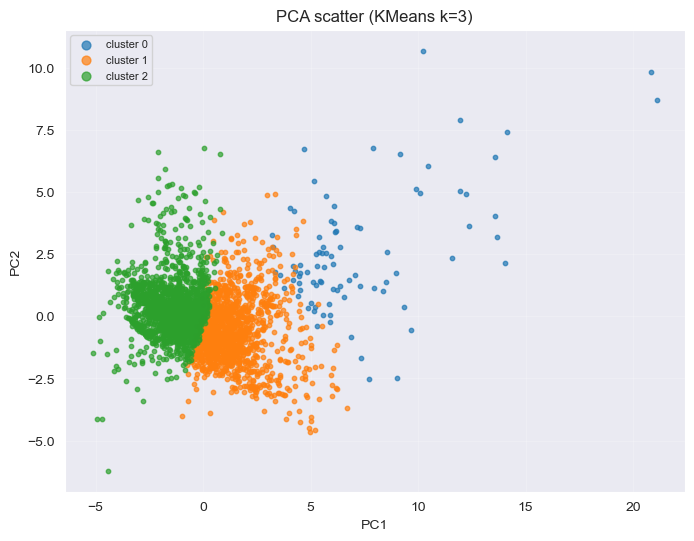

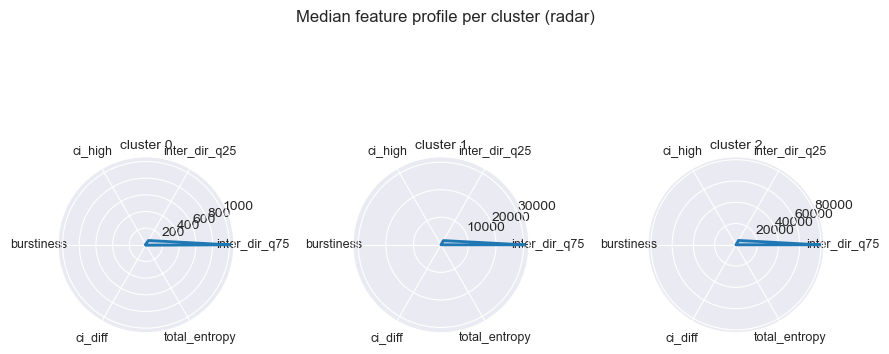

In [98]:
results = segment_wallets(df_features.dropna(), kmeans_k=3, dbscan_eps=0.8, dbscan_min_samples=4)

In [86]:
df_features = pd.concat([
    df_features,
    results['kmeans']['labels'].rename('kmeans_cluster')
], axis=1)

In [87]:
df_features

,wallet_id,inter_dir_q25,inter_dir_q75,burstiness,ci_low,ci_high,ci_diff,hourly_activity_entropy,corr_vol_price_change,corr_vol_price_var,corr_vol_total,seller_entropy,buyer_entropy,total_entropy,RVI,DA,kmeans_cluster
1,3,11.334127,923.333500,4.073870,2.707111,4.987659,2.280548,3.005802,0.004572,0.373802,0.570454,4.319869,4.034076,8.353945,1.124678,0.198730,1
2,5,2082.892340,17220.403000,8.781987,1.290587,9.457724,8.167136,3.111425,-0.048225,0.088345,0.446239,3.905228,3.976908,7.882136,0.052417,0.012707,0
3,6,2217.443355,14453.644126,2.196128,1.547336,2.641356,1.094020,3.115243,-0.099909,0.161523,0.418365,3.532740,3.549585,7.082325,0.085800,0.015799,1
4,7,785.130000,6752.205922,2.611751,1.750383,3.230792,1.480409,3.132419,-0.055087,0.079607,0.476944,3.924761,3.937603,7.862364,0.057368,0.013864,1
5,8,14.615521,104.695393,1.300625,1.280839,1.327068,0.046229,3.173691,-0.006056,0.393796,0.640694,5.799521,5.765290,11.564812,0.688442,0.151884,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
10584,251137,1314.486750,8296.305750,1.583542,0.545993,1.868076,1.322083,1.729820,0.972792,0.937479,-0.077244,2.771520,2.721201,5.492721,0.730368,0.154958,1
10604,257765,178.923500,9695.670250,1.697913,0.123435,1.715385,1.591950,1.011404,0.384991,-1.000000,0.517113,1.068948,1.068948,2.137896,0.000000,0.000000,2
10608,258256,63.499500,84.923000,1.740085,0.109461,1.793713,1.684253,0.693147,1.000000,1.000000,-1.000000,1.034172,1.041825,2.075996,0.796244,0.241591,2
10609,258424,146.065000,741.680500,1.011165,0.320697,1.348015,1.027319,1.039721,-0.265874,0.975753,0.903758,1.733902,1.749888,3.483791,0.309151,0.080906,2


In [88]:
df_all.groupby("wallet_id")["size"].sum().reset_index().rename({"size": "volume"}, axis=1)

,wallet_id,volume
0,1,4800.000000
1,3,711997.875000
2,5,101469.781250
3,6,160148.187500
4,7,216830.234375
...,...,...
10630,271895,637.720032
10631,272337,119.320007
10632,272404,1919.800049
10633,274311,5.420000


In [89]:
df_features

,wallet_id,inter_dir_q25,inter_dir_q75,burstiness,ci_low,ci_high,ci_diff,hourly_activity_entropy,corr_vol_price_change,corr_vol_price_var,corr_vol_total,seller_entropy,buyer_entropy,total_entropy,RVI,DA,kmeans_cluster
1,3,11.334127,923.333500,4.073870,2.707111,4.987659,2.280548,3.005802,0.004572,0.373802,0.570454,4.319869,4.034076,8.353945,1.124678,0.198730,1
2,5,2082.892340,17220.403000,8.781987,1.290587,9.457724,8.167136,3.111425,-0.048225,0.088345,0.446239,3.905228,3.976908,7.882136,0.052417,0.012707,0
3,6,2217.443355,14453.644126,2.196128,1.547336,2.641356,1.094020,3.115243,-0.099909,0.161523,0.418365,3.532740,3.549585,7.082325,0.085800,0.015799,1
4,7,785.130000,6752.205922,2.611751,1.750383,3.230792,1.480409,3.132419,-0.055087,0.079607,0.476944,3.924761,3.937603,7.862364,0.057368,0.013864,1
5,8,14.615521,104.695393,1.300625,1.280839,1.327068,0.046229,3.173691,-0.006056,0.393796,0.640694,5.799521,5.765290,11.564812,0.688442,0.151884,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
10584,251137,1314.486750,8296.305750,1.583542,0.545993,1.868076,1.322083,1.729820,0.972792,0.937479,-0.077244,2.771520,2.721201,5.492721,0.730368,0.154958,1
10604,257765,178.923500,9695.670250,1.697913,0.123435,1.715385,1.591950,1.011404,0.384991,-1.000000,0.517113,1.068948,1.068948,2.137896,0.000000,0.000000,2
10608,258256,63.499500,84.923000,1.740085,0.109461,1.793713,1.684253,0.693147,1.000000,1.000000,-1.000000,1.034172,1.041825,2.075996,0.796244,0.241591,2
10609,258424,146.065000,741.680500,1.011165,0.320697,1.348015,1.027319,1.039721,-0.265874,0.975753,0.903758,1.733902,1.749888,3.483791,0.309151,0.080906,2


In [90]:
df_features = df_features.merge(
    df_all.groupby("wallet_id")["size"].sum().reset_index().rename({"size": "volume"}, axis=1),
    on="wallet_id",
    how="inner",
).merge(
    df_all.groupby("wallet_id")["size"].count().reset_index().rename({"size": "count"}, axis=1),
    on="wallet_id",
    how="inner",
)

df_features

,wallet_id,inter_dir_q25,inter_dir_q75,burstiness,ci_low,ci_high,ci_diff,hourly_activity_entropy,corr_vol_price_change,corr_vol_price_var,corr_vol_total,seller_entropy,buyer_entropy,total_entropy,RVI,DA,kmeans_cluster,volume,count
0,3,11.334127,923.333500,4.073870,2.707111,4.987659,2.280548,3.005802,0.004572,0.373802,0.570454,4.319869,4.034076,8.353945,1.124678,0.198730,1,7.119979e+05,3937
1,5,2082.892340,17220.403000,8.781987,1.290587,9.457724,8.167136,3.111425,-0.048225,0.088345,0.446239,3.905228,3.976908,7.882136,0.052417,0.012707,0,1.014698e+05,2156
2,6,2217.443355,14453.644126,2.196128,1.547336,2.641356,1.094020,3.115243,-0.099909,0.161523,0.418365,3.532740,3.549585,7.082325,0.085800,0.015799,1,1.601482e+05,3275
3,7,785.130000,6752.205922,2.611751,1.750383,3.230792,1.480409,3.132419,-0.055087,0.079607,0.476944,3.924761,3.937603,7.862364,0.057368,0.013864,1,2.168302e+05,5523
4,8,14.615521,104.695393,1.300625,1.280839,1.327068,0.046229,3.173691,-0.006056,0.393796,0.640694,5.799521,5.765290,11.564812,0.688442,0.151884,1,4.276013e+06,170994
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2997,251137,1314.486750,8296.305750,1.583542,0.545993,1.868076,1.322083,1.729820,0.972792,0.937479,-0.077244,2.771520,2.721201,5.492721,0.730368,0.154958,1,1.308420e+04,14
2998,257765,178.923500,9695.670250,1.697913,0.123435,1.715385,1.591950,1.011404,0.384991,-1.000000,0.517113,1.068948,1.068948,2.137896,0.000000,0.000000,2,2.866000e+01,6
2999,258256,63.499500,84.923000,1.740085,0.109461,1.793713,1.684253,0.693147,1.000000,1.000000,-1.000000,1.034172,1.041825,2.075996,0.796244,0.241591,2,1.076200e+02,8
3000,258424,146.065000,741.680500,1.011165,0.320697,1.348015,1.027319,1.039721,-0.265874,0.975753,0.903758,1.733902,1.749888,3.483791,0.309151,0.080906,2,3.086560e+03,8


In [92]:
df_features[df_features["kmeans_cluster"] == 0]

,wallet_id,inter_dir_q25,inter_dir_q75,burstiness,ci_low,ci_high,ci_diff,hourly_activity_entropy,corr_vol_price_change,corr_vol_price_var,corr_vol_total,seller_entropy,buyer_entropy,total_entropy,RVI,DA,kmeans_cluster,volume,count
1,5,2082.892340,17220.403000,8.781987,1.290587,9.457724,8.167136,3.111425,-0.048225,0.088345,0.446239,3.905228,3.976908,7.882136,0.052417,0.012707,0,1.014698e+05,2156
14,20,13.278456,184.033750,4.933187,4.366404,5.416437,1.050033,3.052925,0.112776,0.598628,0.643135,4.874274,5.102214,9.976488,0.970933,0.177160,0,6.478519e+05,9632
23,34,25.125593,506.373250,4.734360,4.037544,5.444915,1.407371,3.101964,0.153907,0.565873,0.652001,5.485822,5.418394,10.904215,0.689981,0.144571,0,3.346721e+05,9852
29,62,284.370774,2780.087273,7.761023,1.815473,9.434753,7.619280,3.158462,-0.088038,0.163431,0.628873,4.666066,4.621637,9.287703,0.987529,0.139714,0,1.557029e+06,5997
35,85,34.049760,94.945994,13.720417,11.641371,16.593143,4.951772,3.126737,-0.110509,0.018358,0.264804,3.658515,3.426711,7.085226,0.155879,0.076613,0,4.786826e+04,10866
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2689,84067,39.234368,45.393678,13.828833,0.822048,17.298374,16.476326,1.932829,0.322974,0.400633,-0.044730,2.579134,2.510681,5.089815,1.266845,0.478949,0,1.510600e+03,482
2743,98327,5.475500,74.800795,11.711992,7.513609,14.965302,7.451692,2.494943,0.164916,-0.002897,0.132542,2.560598,2.684276,5.244874,0.890133,0.282156,0,2.472040e+03,949
2858,168886,24.861000,530.573500,7.527589,1.760288,8.088353,6.328065,2.654836,-0.290300,0.125012,0.117773,3.115374,2.655494,5.770868,0.856950,0.187084,0,2.635382e+04,350
2943,190781,3.223000,15.014000,7.470498,3.580382,8.910030,5.329648,1.654269,0.033240,0.567107,0.404739,2.897736,2.735586,5.633322,0.435913,0.110213,0,3.421496e+04,850
